#  House Prices Regression

In this project, we will attempt to create a model to predict house prices based on its characteristics.

# Loading data 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train.csv').drop(columns=["Id"])

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploratory Data Analysis 

Target column is skewed to the right. Since linear models lose performance considerably when the target column isn't normally distributed, we will perform transformations to convert it.

In [5]:
price_col = "SalePrice"

In [6]:
train.corr()[[price_col]].sort_values(by=price_col, ascending=False).head()

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431


In [7]:
from scipy.stats import skew, norm
import numpy as np

In [8]:
skew(train[price_col])

1.880940746034036

Text(0.5, 1.0, 'Distribution of SalePrice')

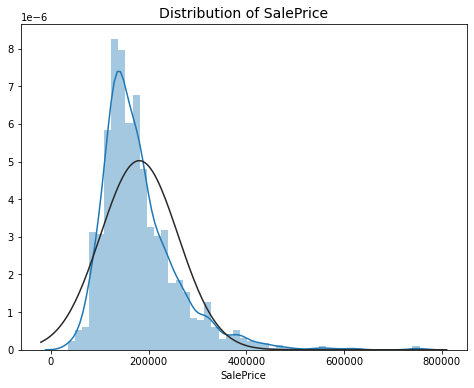

In [9]:
plt.figure(figsize=(8, 6))
sns.distplot(train[price_col], fit=norm)

plt.title("Distribution of SalePrice", fontsize=14)

In [10]:
norm_price_col = "NormalizedPrice"
train[norm_price_col] = np.log1p(train[price_col])

In [11]:
skew(train[norm_price_col])

0.12122191311528359

Mean:  12.024057394918406
Std:  0.39931245219387496


Text(0.5, 1.0, 'Distribution of normalized SalePrice')

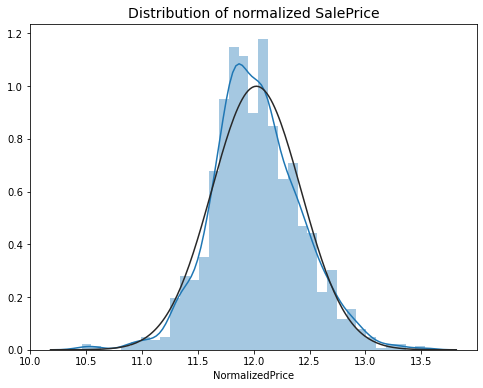

In [12]:
plt.figure(figsize=(8, 6))
(mean, std) = norm.fit(train[norm_price_col])
sns.distplot(train[norm_price_col], fit=norm)
print ("Mean: ", mean)
print ("Std: ", std)

plt.title("Distribution of normalized SalePrice", fontsize=14)

# Feature Engineering 

We have considerable amount of records with missing data. Luckly for us, a text file was provided along with the dataset. With its help, we can more educatedly guess how to fill them.

In [13]:
li = []
no_rows = train.shape[0]
for col in train.columns:
    null_pct = 100*(train[col].isna().sum() / no_rows)
    if null_pct:
        li.append([col, null_pct])

nulls = pd.DataFrame(li, columns=["Column", "NullPct"]).sort_values("NullPct", ascending=False)

Text(0.5, 1.0, 'Columns with Missing Values')

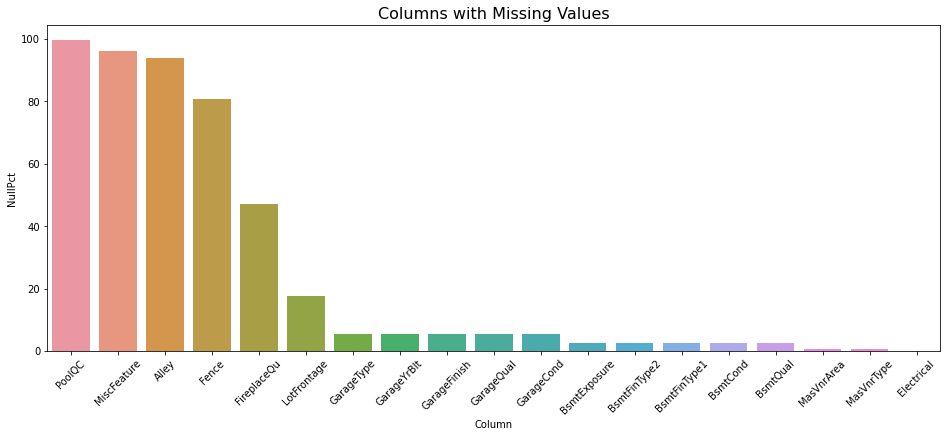

In [14]:
plt.figure(figsize=(16, 6))
sns.barplot(data=nulls, x="Column", y="NullPct")
plt.xticks(rotation=45)
plt.title("Columns with Missing Values", fontsize=16)

In [15]:
def handle_missing_data(df):
    # According to the text file, NaN values on theses columns mean lack of the features
    fill_none = ["PoolQC", "MiscFeature", "Alley", "Fence",
                 "FireplaceQu", 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond',
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', "MasVnrType"]

    for col in fill_none:
        df[col] = df[col].fillna("None")
    
    fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'MasVnrArea']
    for col in fill_zero:
        df[col] = df[col].fillna(0)

    # Since we have few missing values for these features, we will simply use the mode
    fill_mode = ['SaleType', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Electrical', 'MSZoning']
    for col in fill_mode:
        df[col] = df[col].fillna(df[col].mode()[0])

    df["Functional"] = df["Functional"].fillna("Typ")

    # It's reasonable to fill Lot Frontage based on the neighborhood
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

    # According to the text file, this feature is quite meaningless. Given the features we have, we'll just drop it.
    df = df.drop(columns=["Utilities"])

    return df

In [16]:
train = handle_missing_data(train)

By label encoding, we convert categorical and ordinal features into numerical.

In [17]:
def label_encode_ordinal_features(df):
    ordinal_features = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

    from sklearn.preprocessing import LabelEncoder

    for feature in ordinal_features:
        encoder = LabelEncoder()
        df[feature] = encoder.fit_transform(df[feature])

    return df
        

We'll create a total square footage feature by adding individuals square footage.

In [18]:
def get_total_sq_footage(df):
    df["TotalSF"] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    return df

In [19]:
train = get_total_sq_footage(train)

In [20]:
train = label_encode_ordinal_features(train)

We'll also use sklearn's Power Transformer to transform features that are highly skewed.

In [21]:
from sklearn.preprocessing import PowerTransformer

def normalize_skewed_features(df):
    numerical_features = [col for col in df.columns if df[col].dtype == np.int or df[col].dtype == np.float]
    numerical_features.remove("NormalizedPrice")
    numerical_features.remove("SalePrice")

    for feature in numerical_features:
        if skew(df[feature]) > abs(0.5):
            pt = PowerTransformer()
            df[feature] = pt.fit_transform(df[feature].values.reshape(-1, 1))

    return df

In [22]:
train = normalize_skewed_features(train)

In [23]:
def split_categorical_features_into_dummies(df):
    return pd.get_dummies(df)

In [24]:
train = split_categorical_features_into_dummies(train)

In [25]:
def preprocess(df):
    df = handle_missing_data(df)
    df = categorize_numerical_features(df)
    df = label_encode_ordinal_features(df)
    df = get_total_sq_footage(df)
    df = normalize_numerical_features(df)
    df = split_categorical_features_into_dummies(df)

    return df

# Model Selection 

In [26]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost

In [27]:
X = train.drop(columns=["SalePrice", "NormalizedPrice"])
y = train["NormalizedPrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=.33)

In [28]:
def get_rmse_cv(model):
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=101)
    return np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))

In [29]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=.00000005, max_iter=10**5))
bagging = BaggingRegressor(n_estimators=100)
rf = RandomForestRegressor(n_estimators=100)
gb = GradientBoostingRegressor(n_estimators=100)
xg = xgboost.XGBRegressor(n_estimators=100)

Lasso
BaggingRegressor
RandomForestRegressor
GradientBoostingRegressor
XGBRegressor


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

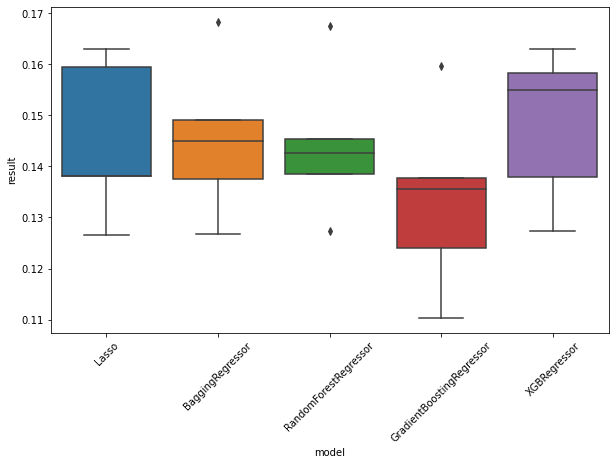

In [30]:
models = [
    lasso,
    bagging,
    rf,
    gb,
    xg
]

agg = []

for model in models:
    if model.__class__.__name__ == "Pipeline":
        model_name = model[1].__class__.__name__
    else:
        model_name = model.__class__.__name__

    print (model_name)
    rmse = get_rmse_cv(model)
    for result in rmse:
        agg.append([model_name, result])


cv_df = pd.DataFrame(agg, columns=["model", "result"])
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df, x="model", y="result")
plt.xticks(rotation=45)

# Modeling: Stacked Regressor

As we could see, no models really stood out. So, to minimize errors, we'll use a Stacking Regressor. By running multiple models and using their outputs as inputs to a final estimator, we reduce bias and variance.

To verify its effectiveness, we'll also fit a Gradient Boosting Regressor, which produced the best results, and compare performances.

In [31]:
from sklearn.ensemble import StackingRegressor

In [32]:
st_reg = StackingRegressor(estimators=[("lasso", lasso),
                                       ("bag", bagging),
                                       ("rf", rf),
                                       ("gb", gb),
                                       ("xg", xg)],
                           n_jobs=-1,
                           cv=KFold(n_splits=5, shuffle=True, random_state=101))

In [33]:
st_reg.fit(X_train, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=101, shuffle=True),
                  estimators=[('lasso',
                               Pipeline(steps=[('robustscaler', RobustScaler()),
                                               ('lasso',
                                                Lasso(alpha=5e-08,
                                                      max_iter=100000))])),
                              ('bag', BaggingRegressor(n_estimators=100)),
                              ('rf', RandomForestRegressor()),
                              ('gb', GradientBoostingRegressor()),
                              ('xg',
                               XGBRegressor(base_score=None, booster=None,
                                            colsamp...
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                

In [34]:
y_pred = st_reg.predict(X_test)

In [35]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.12618908743386203

In [36]:
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [37]:
y_pred_gb = gb.predict(X_test)

In [38]:
np.sqrt(mean_squared_error(y_test, y_pred_gb))

0.13580447829545242

As we can see, the Stacked model had a RMSE of .1261, whereas the Gradient Boosting had .1358.

Text(0, 0.5, 'Predicted')

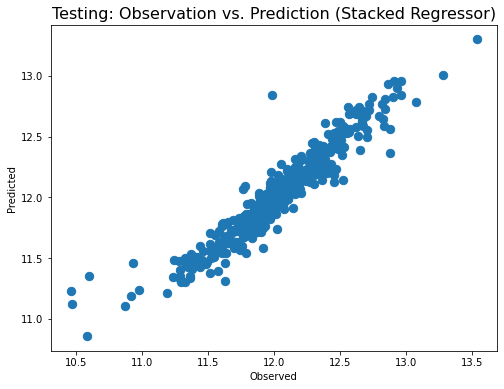

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, s=70)
plt.title("Testing: Observation vs. Prediction (Stacked Regressor)", fontsize=16)
plt.xlabel("Observed")
plt.ylabel("Predicted")

Text(0.5, 1.0, 'Testing: Residuals (Stacked Regressor)')

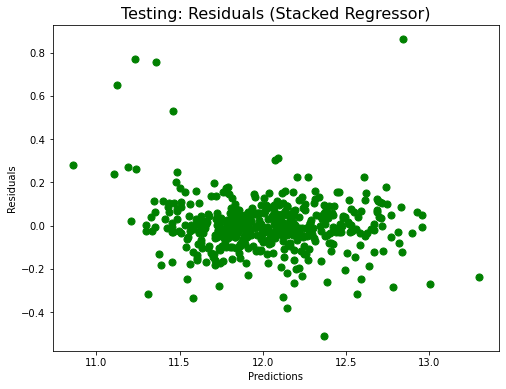

In [41]:
residuals = y_pred - y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, s=50, color="green")
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Testing: Residuals (Stacked Regressor)", fontsize=16)

By plotting the residuals, we can see that errors are, overall, low and consistent. Indeed, there are some anomalies but they aren't numerous and don't compromise the model's integrity.

# Conclusion 

In this notebook, we were able to create a solid model capable of estimating the sale price of a house based on its features. Since they were numerous, we had to do some Feature Engineering to deal with missing values and create useful variables.

Also, by combining multiple models into a Stacked one, we were able to minimize erros due to bias and variance